# Assignment 5: Model Evaluation
## Comprehensive Evaluation of Text Classification Model

This notebook evaluates the trained model on the test set with detailed metrics and analysis.

## 1. Setup and Load Model

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All imports successful!")

✓ All imports successful!


In [2]:
# Load data
data_path = Path('./data/data.json')
with open(data_path, 'r') as f:
    data = json.load(f)

texts = [item['abstract'] for item in data]
labels = np.array([item['relevance'] for item in data])

print(f"✓ Loaded {len(texts)} samples")

✓ Loaded 300 samples


In [3]:
# Load embedding model and generate embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(texts, show_progress_bar=True)
print(f"✓ Generated embeddings with shape {embeddings.shape}")

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Generated embeddings with shape (300, 384)


In [4]:
# Recreate the same data splits
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Test set size: {len(X_test)}")

Test set size: 45


In [5]:
# Load the trained classifier
model_dir = Path('./models')
classifier_path = model_dir / 'classifier.pkl'

with open(classifier_path, 'rb') as f:
    classifier = pickle.load(f)

print(f"✓ Loaded classifier from {classifier_path}")

✓ Loaded classifier from models/classifier.pkl


## 2. Test Set Evaluation

In [6]:
# Generate predictions
y_test_pred = classifier.predict(X_test)
y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\n" + "="*50)
print("TEST SET PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"F1-score:  {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")
print("="*50)


TEST SET PERFORMANCE METRICS
Accuracy:  0.8444
F1-score:  0.5882
Precision: 0.5556
Recall:    0.6250
AUC-ROC:   0.9122


In [7]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Not Relevant', 'Relevant'],
                          digits=4))


Detailed Classification Report:
              precision    recall  f1-score   support

Not Relevant     0.9167    0.8919    0.9041        37
    Relevant     0.5556    0.6250    0.5882         8

    accuracy                         0.8444        45
   macro avg     0.7361    0.7584    0.7462        45
weighted avg     0.8525    0.8444    0.8480        45



## 3. Confusion Matrix Analysis

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

print("\nConfusion Matrix:")
print(f"  True Negatives (TN):  {cm[0, 0]}")
print(f"  False Positives (FP): {cm[0, 1]}")
print(f"  False Negatives (FN): {cm[1, 0]}")
print(f"  True Positives (TP):  {cm[1, 1]}")

# Calculate derived metrics
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

print(f"\nDerived Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity:          {specificity:.4f}")


Confusion Matrix:
  True Negatives (TN):  33
  False Positives (FP): 4
  False Negatives (FN): 3
  True Positives (TP):  5

Derived Metrics:
  Sensitivity (Recall): 0.6250
  Specificity:          0.8919


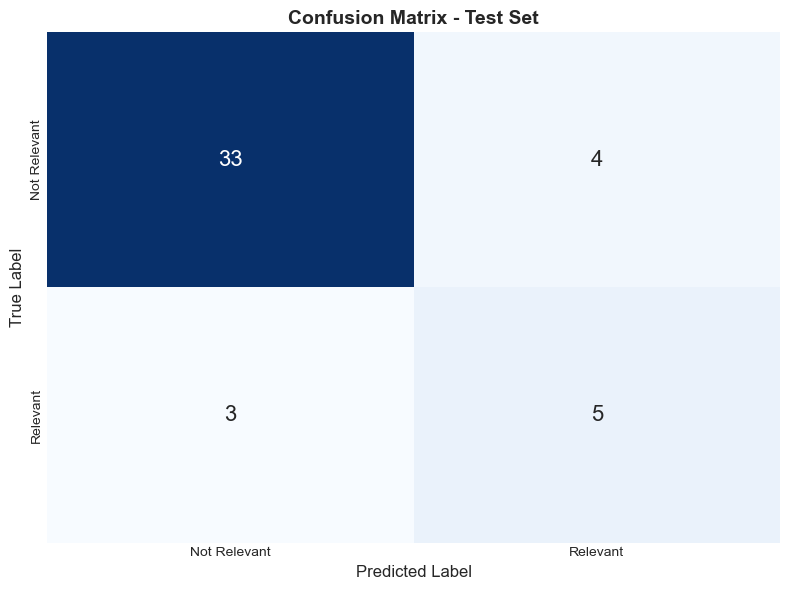

✓ Confusion matrix saved to evaluation_confusion_matrix.png


In [9]:
# Visualize confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Relevant', 'Relevant'],
            yticklabels=['Not Relevant', 'Relevant'],
            ax=ax, annot_kws={'size': 16})
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./evaluation_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to evaluation_confusion_matrix.png")

## 4. ROC Curve Analysis

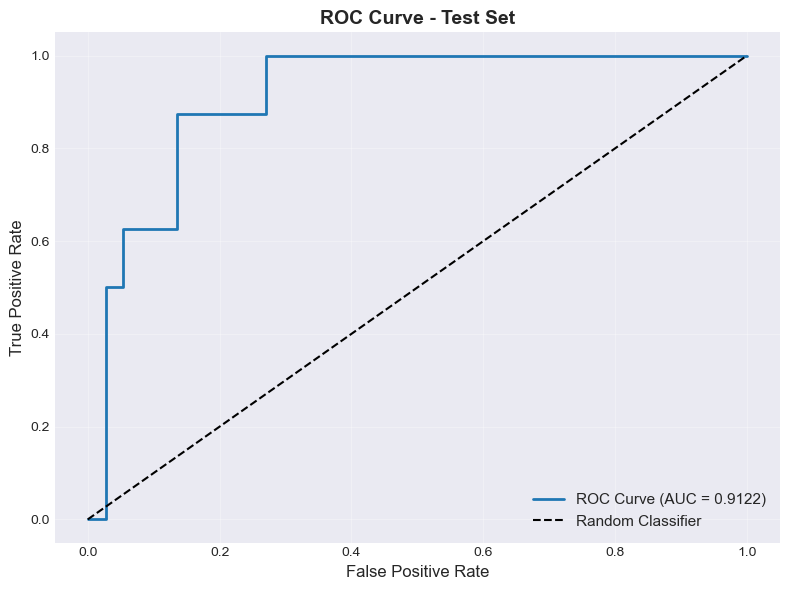

✓ ROC curve saved to evaluation_roc_curve.png


In [10]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {test_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./evaluation_roc_curve.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved to evaluation_roc_curve.png")

## 5. Performance Comparison Across Datasets

In [11]:
# Evaluate on train and validation sets for comparison
y_train_pred = classifier.predict(X_train)
y_train_pred_proba = classifier.predict_proba(X_train)[:, 1]

y_val_pred = classifier.predict(X_val)
y_val_pred_proba = classifier.predict_proba(X_val)[:, 1]

# Calculate metrics for all sets
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Create comparison table
metrics_df = pd.DataFrame({
    'Train': [train_accuracy, train_f1, train_precision, train_recall],
    'Validation': [val_accuracy, val_f1, val_precision, val_recall],
    'Test': [test_accuracy, test_f1, test_precision, test_recall]
}, index=['Accuracy', 'F1-score', 'Precision', 'Recall'])

print("\nPerformance Metrics Across Datasets:")
print(metrics_df.to_string())


Performance Metrics Across Datasets:
              Train  Validation      Test
Accuracy   0.819048    0.822222  0.844444
F1-score   0.648148    0.600000  0.588235
Precision  0.492958    0.500000  0.555556
Recall     0.945946    0.750000  0.625000


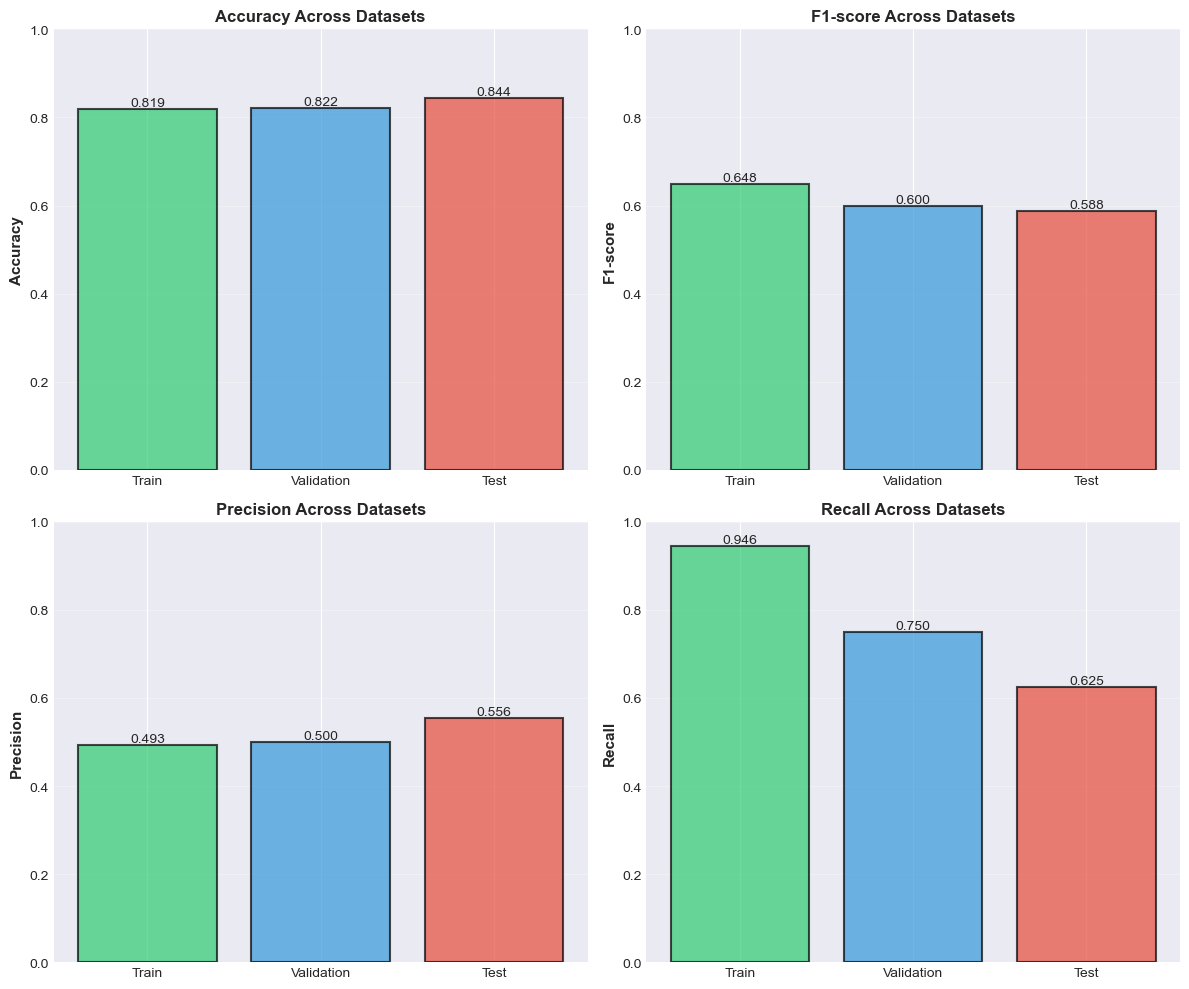

✓ Metrics comparison saved to evaluation_metrics_comparison.png


In [12]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = metrics_df.loc[metric].values
    datasets = ['Train', 'Validation', 'Test']
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    bars = ax.bar(datasets, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_title(f'{metric} Across Datasets', fontsize=12, fontweight='bold')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./evaluation_metrics_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison saved to evaluation_metrics_comparison.png")

## 6. Prediction Confidence Analysis

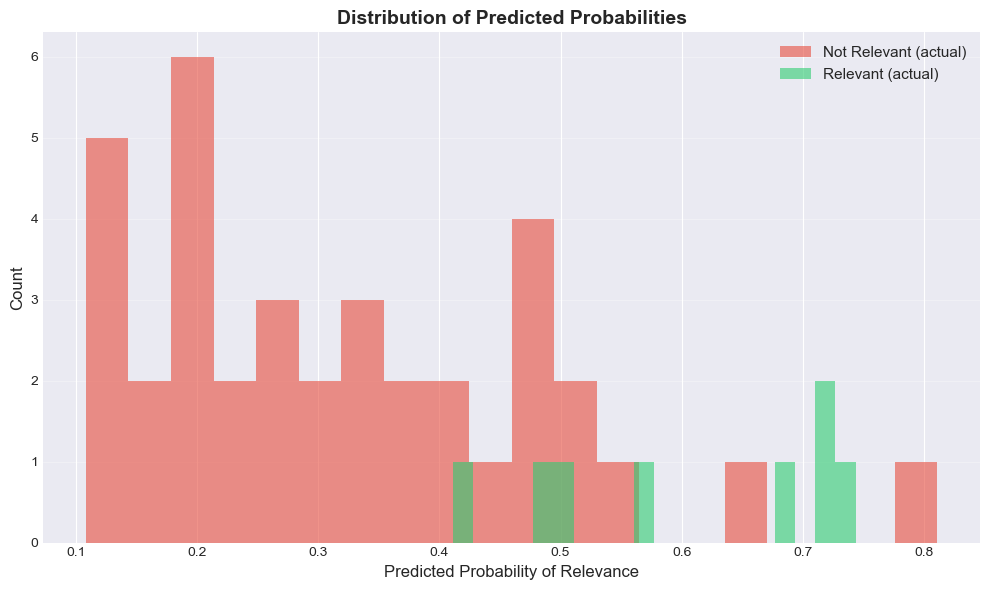

✓ Confidence distribution saved to evaluation_confidence_distribution.png

Confidence Statistics:
  Relevant samples - Mean probability: 0.6030
  Relevant samples - Std probability: 0.1201
  Not Relevant samples - Mean probability: 0.3195
  Not Relevant samples - Std probability: 0.1611


In [13]:
# Analyze prediction confidence
fig, ax = plt.subplots(figsize=(10, 6))

# Separate predictions by actual label
positive_proba = y_test_pred_proba[y_test == 1]
negative_proba = y_test_pred_proba[y_test == 0]

ax.hist(negative_proba, bins=20, alpha=0.6, label='Not Relevant (actual)', color='#e74c3c')
ax.hist(positive_proba, bins=20, alpha=0.6, label='Relevant (actual)', color='#2ecc71')
ax.set_xlabel('Predicted Probability of Relevance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./evaluation_confidence_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Confidence distribution saved to evaluation_confidence_distribution.png")
print(f"\nConfidence Statistics:")
print(f"  Relevant samples - Mean probability: {positive_proba.mean():.4f}")
print(f"  Relevant samples - Std probability: {positive_proba.std():.4f}")
print(f"  Not Relevant samples - Mean probability: {negative_proba.mean():.4f}")
print(f"  Not Relevant samples - Std probability: {negative_proba.std():.4f}")

## 7. Error Analysis

In [14]:
# Identify and analyze errors
errors = y_test_pred != y_test
correct = y_test_pred == y_test

print(f"\nError Analysis:")
print(f"  Total test samples: {len(y_test)}")
print(f"  Correct predictions: {correct.sum()} ({correct.sum()/len(y_test)*100:.1f}%)")
print(f"  Incorrect predictions: {errors.sum()} ({errors.sum()/len(y_test)*100:.1f}%)")

# False Positives
false_pos = (y_test_pred == 1) & (y_test == 0)
print(f"\n  False Positives (predicted 1, actual 0): {false_pos.sum()}")

# False Negatives
false_neg = (y_test_pred == 0) & (y_test == 1)
print(f"  False Negatives (predicted 0, actual 1): {false_neg.sum()}")


Error Analysis:
  Total test samples: 45
  Correct predictions: 38 (84.4%)
  Incorrect predictions: 7 (15.6%)

  False Positives (predicted 1, actual 0): 4
  False Negatives (predicted 0, actual 1): 3


## 8. Final Evaluation Summary

In [15]:
print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)

print(f"\nTest Dataset:")
print(f"  Size: {len(y_test)} samples")
print(f"  Relevant: {(y_test == 1).sum()}")
print(f"  Not Relevant: {(y_test == 0).sum()}")

print(f"\nPerformance Metrics (Test Set):")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  F1-score:  {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  AUC-ROC:   {test_auc:.4f}")

print(f"\nModel Characteristics:")
print(f"  Embedding Model: SentenceTransformer (all-MiniLM-L6-v2)")
print(f"  Classifier: Logistic Regression")
print(f"  Class Weight: Balanced")
print(f"  Training Samples: {len(X_train)}")

print(f"\nKey Findings:")
if test_f1 > 0.7:
    print(f"  ✓ Good F1-score performance")
if test_precision > 0.7:
    print(f"  ✓ Good precision - low false positives")
if test_recall > 0.7:
    print(f"  ✓ Good recall - low false negatives")
if test_accuracy > 0.8:
    print(f"  ✓ High overall accuracy")

print("\n" + "="*60)


FINAL EVALUATION SUMMARY

Test Dataset:
  Size: 45 samples
  Relevant: 8
  Not Relevant: 37

Performance Metrics (Test Set):
  Accuracy:  0.8444
  F1-score:  0.5882
  Precision: 0.5556
  Recall:    0.6250
  AUC-ROC:   0.9122

Model Characteristics:
  Embedding Model: SentenceTransformer (all-MiniLM-L6-v2)
  Classifier: Logistic Regression
  Class Weight: Balanced
  Training Samples: 210

Key Findings:
  ✓ High overall accuracy

